In [1]:
%matplotlib inline
#%matplotlib
import cv2 
import imageio
import pickle
import pydicom
import random
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from scipy.sparse import csr_matrix

import sys
sys.path.append('../metal')

In [2]:
data_path = '../data/mr/dev/'
labels = pd.read_csv(data_path+'labels.csv')

In [3]:
def findLeftArea(mask):
    area = np.sum(np.sum(mask==1.0,axis=2),axis=1) # area of left atrium
    return area

In [4]:
def findRightArea(mask):
    area = np.sum(np.sum(mask==2.0,axis=2),axis=1) # area of left atrium
    return area

In [5]:
def findLeftPerimeter(mask):
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    perimeter = np.zeros((50,1))
    for frame in range(50):
        regions = regionprops(mask[frame])
        perimeter[frame] = regions[0].perimeter
    
    return perimeter

In [6]:
def findRightPerimeter(mask):
    mask[mask!=2.0] = 0.0
    mask = mask.astype(int)
    perimeter = np.zeros((50,1))
    for frame in range(50):
        regions = regionprops(mask[frame])
        perimeter[frame] = regions[0].perimeter
    
    return perimeter

In [7]:
def findLeftEF(mask):
    area = findLeftArea(mask)
    ejection_fraction = min(area)/max(area)
    
    return ejection_fraction

In [8]:
def findRightEF(mask):
    area = findRightArea(mask)
    ejection_fraction = min(area)/max(area)
    
    return ejection_fraction

In [9]:
def findLeftAreaVar(mask):
    area = findLeftArea(mask)
    area_var = np.var(area)
    
    return area_var

In [10]:
def findRightAreaVar(mask):
    area = findRightArea(mask)
    area_var = np.var(area)
    
    return area_var

In [11]:
def findFrameAreaRatio(mask):
    left_area = findLeftArea(mask)
    right_area = findRightArea(mask)
    area_ratio = np.mean(np.divide(left_area,right_area))
    
    return area_ratio

In [12]:
def findFrameRatioVar(mask):
    left_area = findLeftArea(mask)
    right_area = findRightArea(mask)
    ratio_var = np.var(np.divide(left_area,right_area))
    
    return ratio_var

In [13]:
def findAreaPerimeterRatio(mask):
    area=  findLeftArea(mask)
    perimeter = findLeftPerimeter(mask)
    #print(perimeter)
    
    ratio = np.divide(area, np.power(perimeter,2))
    #ratio = np.divide(area, perimeter)
    #print(np.nanmean(ratio))
    return np.nanmean(ratio)

In [14]:
def findAreaPerimeterRatioVar(mask):
    area=  findLeftArea(mask)
    perimeter = findLeftPerimeter(mask)
    
    ratio = np.divide(area, np.power(perimeter,2))
    #ratio = np.divide(area, perimeter)
    return np.nanvar(ratio)

In [15]:
def OCIndex2Label(index_open, index_close):
    """
    Converts from open and close index to frame-wise labels   
    
    Params
    -------
    index_open: int
    index_close: int
    
    Return
    -------
    frame_labels: numpy array of shape (1,50)
    
    """
    index_open = int(index_open)
    index_close = int(index_close)
    
    frame_labels = np.zeros([1,50]);
    if(index_close >= index_open):
        frame_labels[0,index_open:index_close] = 1
    else:
        frame_labels[0,index_open:50] = 1
        frame_labels[0,0:index_close] = 1
        
    return frame_labels   

In [16]:
def findAreaLabel(mask):
    '''
    function to find labels based on area of left atrium
    
    Input
    -----
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    area_la = np.sum(np.sum(mask==1.0,axis=2),axis=1) # area of left atrium
    
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(area_la)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(area_la)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-3)%50
    index_high = (index_close+2)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [17]:
def findPerimeterLabel(mask):
    '''
    function to find labels based on perimeter of left atrium
    
    Input
    -----
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    
    # finding perimeter of left atrium 
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    perimeter = np.zeros((50,1))
    for frame in range(50):
        regions = regionprops(mask[frame])
        perimeter[frame] = regions[0].perimeter
        
    # mitral valve opens - when perimeter is largest
    index_open = np.argmax(perimeter)

    # mitral valve closes - when perimeter is smallest
    index_close = np.argmin(perimeter)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-3)%50
    index_high = (index_close+2)%50
        
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [18]:
def findIntensityLabel(data, mask):
    '''
    function to define labels based on intensity within left atrium
    
    Input
    -----
    data: float (50,208,174)
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    # avg intensity within segment
    mask[mask!=1.0] = 0.0
    area_intensity = np.mean(np.mean(np.multiply(mask,data),axis=2),axis=1)
        
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(area_intensity)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(area_intensity)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
        
    return label

In [19]:
def findIntensityLabel2(data, mask):
    '''
    function to define labels based on intensity along perimeter of left atrium
    
    Input
    -----
    data: float (50,208,174)
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    # avg intensity within segment
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    boundary = find_boundaries(mask,mode='outer')
    intensity = np.mean(np.mean(np.multiply(boundary,data),axis=2),axis=1)
        
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(intensity)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(intensity)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [20]:
def findLabelPrior():
    index_open = 20
    index_close = 1
    
    label = OCIndex2Label(index_open,index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
        
    return label

In [21]:
# define 80% coverage labelling functions
#import import_ipynb
#import labelling_functions_3

def findLFLabelsEg(data,mask):
    '''
    Function computes the LFs for the given data
    Saves the numpy array for each individual PID in the folder specified
    '''
    L = np.zeros((50,5))
    L[:,0] = np.squeeze(np.transpose(findAreaLabel(mask)))
    L[:,1] = np.squeeze(np.transpose(findPerimeterLabel(mask)))
    L[:,2] = np.squeeze(np.transpose(findIntensityLabel(data,mask)))
    L[:,3] = np.squeeze(np.transpose(findIntensityLabel2(data,mask)))
    L[:,4] = np.squeeze(np.transpose(findLabelPrior()))
    #L = L + 1
    
    return L

In [22]:
# call labelling functions, define majority vote classifier 
# return prediction probabilities
import sys
sys.path.append('../heart_mri/metal')
from metal.label_model.baselines import MajorityLabelVoter

def findMajorityPred(data,mask):
    L = findLFLabelsEg(data,mask)
    
    mv = MajorityLabelVoter(seed=123)
    prob = mv.predict_proba(L)
    
    return prob

In [23]:
# define which frames are picked using prediction probabilities 
def findClosedFrames(data,mask):
    prob = findMajorityPred(data,mask)
    
    prob = prob[:,0]
    closed_frames = [i for i,x in enumerate(prob) if x == 1.0]
    
    # returning the first 10 closed frames
    if len(closed_frames) > 10:
        closed_frames = closed_frames[:10]
        
    return closed_frames

In [24]:
def findLeftAtriumIntensity(data,mask):
    masked_data = np.multiply(data,mask)
    frames = findClosedFrames(data,mask)
    
    masked_data = masked_data[frames,:,:]
    masked_data = np.reshape(masked_data,(len(frames),-1))
    
    area_intensity = np.mean(masked_data,axis=1)
    return area_intensity
    

In [25]:
def findLeftAtriumIntensityVar(data,mask):
    masked_data = np.multiply(data,mask)
    frames = findClosedFrames(data,mask)
    
    masked_data = masked_data[frames,:,:]
    masked_data = np.reshape(masked_data,(len(frames),-1))
    
    area_intensity_var = np.var(masked_data,axis=1)
    return area_intensity_var

In [26]:
dev_PIDs = labels.ID
dev_labels = labels.LABEL 

print(dev_PIDs.shape)
print(dev_labels.shape)

(250,)
(250,)


In [27]:
MR_indices = [i for i,x in enumerate(dev_labels) if x == 1.0]
nonMR_indices = [i for i,x in enumerate(dev_labels) if x == 0.0]

MR_PIDs = dev_PIDs[MR_indices[:25]]
nonMR_PIDs = dev_PIDs[nonMR_indices[:25]]

In [28]:
# loading data and mask
data = {}
mask = {} 
Y = {}
for PID in MR_PIDs:
    print(PID)
    data[PID] = np.load(data_path+'la_4ch/'+str(PID)+'.npy')
    mask[PID] = np.load(data_path+'la_4ch_mask/'+str(PID)+'.npy')
    Y[PID] = 1    
    
for PID in nonMR_PIDs:
    print(PID)
    data[PID] = np.load(data_path+'la_4ch/'+str(PID)+'.npy')
    mask[PID] = np.load(data_path+'la_4ch_mask/'+str(PID)+'.npy')
    Y[PID] = 0   

3642274
3294835
2782922
4755232
3973512
5999936
2751831
2357964
4698284
2473769
5795137
2288001
5139473
3138102
2736555
2582951
4264839
3837322
2748855
2480854
3912681
1862574
5028350
3070856
3768159
4696782
2224539
2260153
5347895
1629308
2785839
1590041
5441523
2352684
2737660
2382060
3798342
5842364
4393066
3962069
5306634
1761094
3963033
2437861
5931059
1360459
1393273
5228762
1845554
4072135


In [29]:
MR_left_EF = []
nonMR_left_EF = [] 
MR_right_EF = []
nonMR_right_EF = [] 
MR_left_var = []
nonMR_left_var = []
MR_right_var = []
nonMR_right_var = []
MR_area_ratio = []
nonMR_area_ratio = []
MR_ratio_var = []
nonMR_ratio_var = []
MR_area_perimeter_ratio = []
nonMR_area_perimeter_ratio = []
MR_area_perimeter_ratio_var = []
nonMR_area_perimeter_ratio_var = []

MR_atrium_intensity = np.zeros((25,10))
nonMR_atrium_intensity = np.zeros((25,10))
MR_atrium_intensity_var = np.zeros((25,10))
nonMR_atrium_intensity_var = np.zeros((25,10))

count = 0
for PID in MR_PIDs:
    MR_left_EF.append(findLeftEF(mask[PID]))
    MR_right_EF.append(findRightEF(mask[PID]))
    MR_left_var.append(findLeftAreaVar(mask[PID]))
    MR_right_var.append(findRightAreaVar(mask[PID]))
    MR_area_ratio.append(findFrameAreaRatio(mask[PID]))
    MR_ratio_var.append(findFrameRatioVar(mask[PID]))
    MR_area_perimeter_ratio.append(findAreaPerimeterRatio(mask[PID]))
    MR_area_perimeter_ratio_var.append(findAreaPerimeterRatioVar(mask[PID]))
    
    MR_atrium_intensity[count,:] = findLeftAtriumIntensity(data[PID],mask[PID])
    MR_atrium_intensity_var[count,:] = findLeftAtriumIntensityVar(data[PID],mask[PID])
    count = count+1
    
count = 0
for PID in nonMR_PIDs:
    nonMR_left_EF.append(findLeftEF(mask[PID]))
    nonMR_right_EF.append(findRightEF(mask[PID]))
    nonMR_left_var.append(findLeftAreaVar(mask[PID]))
    nonMR_right_var.append(findRightAreaVar(mask[PID]))
    nonMR_area_ratio.append(findFrameAreaRatio(mask[PID]))
    nonMR_ratio_var.append(findFrameRatioVar(mask[PID]))
    nonMR_area_perimeter_ratio.append(findAreaPerimeterRatio(mask[PID]))
    nonMR_area_perimeter_ratio_var.append(findAreaPerimeterRatioVar(mask[PID]))
    
    nonMR_atrium_intensity[count,:] = findLeftAtriumIntensity(data[PID],mask[PID])
    nonMR_atrium_intensity_var[count,:] = findLeftAtriumIntensityVar(data[PID],mask[PID])
    count = count+1
    

MR_atrium_intensity = np.reshape(MR_atrium_intensity,(250,))
nonMR_atrium_intensity = np.reshape(nonMR_atrium_intensity,(250,))
MR_atrium_intensity_var = np.reshape(MR_atrium_intensity_var,(250,))
nonMR_atrium_intensity_var = np.reshape(nonMR_atrium_intensity_var,(250,))

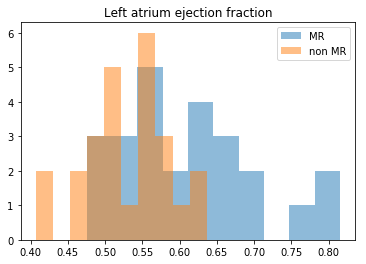

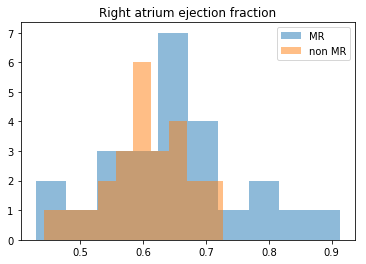

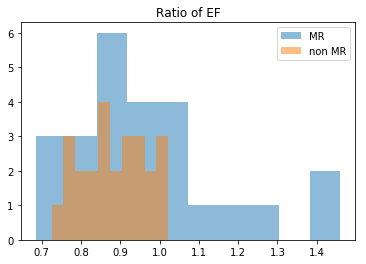

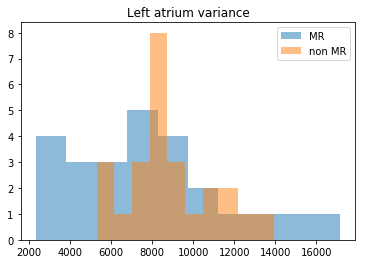

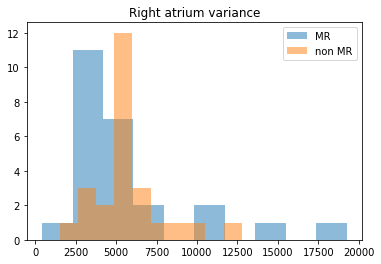

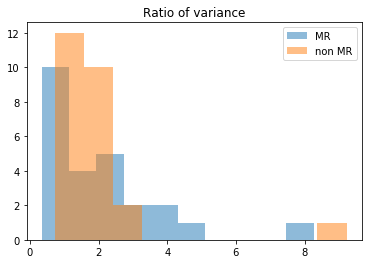

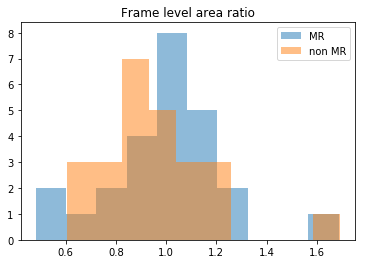

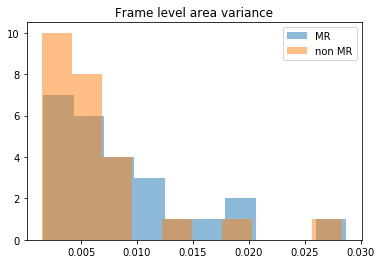

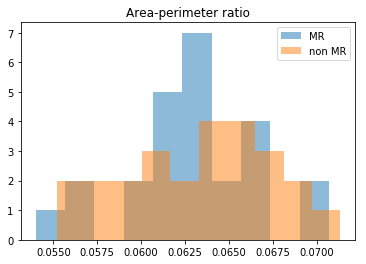

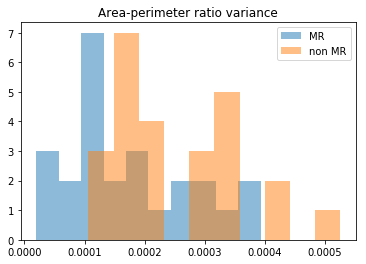

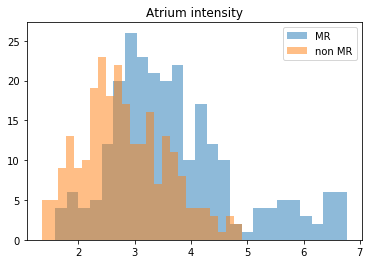

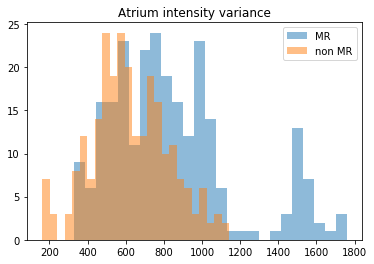

In [30]:
plt.figure()
plt.hist(MR_left_EF, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_left_EF, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Left atrium ejection fraction')
plt.show()


plt.figure()
plt.hist(MR_right_EF, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_right_EF, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Right atrium ejection fraction')
plt.show()

plt.figure()
plt.hist(np.divide(MR_left_EF, MR_right_EF), bins=10, alpha = 0.5, label='MR')
plt.hist(np.divide(nonMR_left_EF, nonMR_right_EF), bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Ratio of EF')
plt.show()

plt.figure()
plt.hist(MR_left_var, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_left_var, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Left atrium variance')
plt.show()

plt.figure()
plt.hist(MR_right_var, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_right_var, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Right atrium variance')
plt.show()


plt.figure()
plt.hist(np.divide(MR_left_var, MR_right_var), bins=10, alpha = 0.5, label='MR')
plt.hist(np.divide(nonMR_left_var, nonMR_right_var), bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Ratio of variance')
plt.show()


plt.figure()
plt.hist(MR_area_ratio, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_area_ratio, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Frame level area ratio')
plt.show()


plt.figure()
plt.hist(MR_ratio_var, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_ratio_var, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Frame level area variance')
plt.show()

plt.figure()
plt.hist(MR_area_perimeter_ratio, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_area_perimeter_ratio, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Area-perimeter ratio')
plt.show()

plt.figure()
plt.hist(MR_area_perimeter_ratio_var, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_area_perimeter_ratio_var, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Area-perimeter ratio variance')
plt.show()


plt.figure()
plt.hist(MR_atrium_intensity, bins=25, alpha = 0.5, label='MR')
plt.hist(nonMR_atrium_intensity, bins=25, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Atrium intensity')
plt.show()

plt.figure()
plt.hist(MR_atrium_intensity_var, bins=25, alpha = 0.5, label='MR')
plt.hist(nonMR_atrium_intensity_var, bins=25, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Atrium intensity variance')
plt.show()